# Quantum Lie-Equivariant GNN (Q-LieEGNN)

In [ ]:
Todo
[X] - Get code for LorentzNet
    [X] - Sanity checking, test for equivariance against Lorentz boosts.
[X] - Implement Lie-EQGNN.
    [X] - Sanity checking, test for equivariance against Lorentz boosts.
[X] - Test training function for classical LorentzNet.
[X] - Test training function for Lie EQGNN.
[X] - Convert Roy's data into LorentzNet format.
[X] - Get a full script for training LieEQGNN.
[ ] - What is performance of LorentzNet vs Lie-EQGNN vs QLorentzNet on the same jet data?
[ ] - What is performance of LorentzNet vs Lie-EQGNN vs QLorentzNet against boosts?
[ ] - What is the performance of LorentzNet vs Lie-EQGNN vs QLorentzNet on noisy data (ie: gaussian)?
[ ] - What is the performance on semi-visible jets (like in hidden valley models) ?
[ ] - Implement Infrared (IR) and possibly Collinear (C) safety in the message passing step.

#### in this task, we were asked to implement and draw the architecture of a possible Quantum Graph Neural Network

I will start from the LorentzNet paper and official implementation, load the quark-gluon tagging data, and perform equivariance tests just for sanity checks, to confirm that the code works.

Once this is done, here I put a simple modification to incorporate parameterized circuits using Pennylane. Once this is done, we test again for equivariance. Once equivariance test is passed, I show equivariance to an arbitrary metric tensor $J$, where the Lorentz boosts are now symmetry-breaking, but rotations about a fixed plane are preserving.

In [2]:
# For Colab
!pip install torch_geometric
!pip install torch_sparse
!pip install torch_scatter


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
  Using cached torch_sparse-0.6.18.tar.gz (209 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-lcy59mga/torch-sparse_ff3c8ac0008f4b1d8e47a3a9bea01e6f/setup.py", line 8, in <module>
          import torch
      ModuleNotFoundError: No module named 'torch'
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for deta

## Two ways of equivariance for QGNNs:

### - Invariant Theory
### - Marco Cerezo, Roy

## Variational circuits

In [171]:
n_qubits = 10

In [172]:
import torch
import pennylane as qml
import torch.nn.functional as F
from torch import nn
from torch_geometric.utils import to_dense_adj


dev = qml.device('default.qubit', wires=n_qubits)


def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])


@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat, q_depth, n_qubits):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)


class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self, n_qubits, q_depth = 1, q_delta=0.001):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.n_qubits = n_qubits
        self.q_depth = q_depth
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # Quantum Embedding (U(X))
        q_in = torch.tanh(input_features) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, self.n_qubits)
        q_out = q_out.to(device)
        # for batch in q_in:
        for elem in q_in:
            # print(quantum_net(elem, self.q_params, self.q_depth, self.n_qubits))
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params, self.q_depth, self.n_qubits)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the batch measurement of the PQC
        return q_out.unsqueeze(0)

In [163]:
import torch
import numpy as np
import energyflow
from scipy.sparse import coo_matrix
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data.distributed import DistributedSampler

def get_adj_matrix(n_nodes, batch_size, edge_mask):
    rows, cols = [], []
    # print(edge_mask[0])
    # raise
    for batch_idx in range(batch_size):
        nn = batch_idx*n_nodes
        x = coo_matrix(edge_mask[batch_idx])
        rows.append(nn + x.row)
        cols.append(nn + x.col)
    rows = np.concatenate(rows)
    cols = np.concatenate(cols)

    edges = [torch.LongTensor(rows), torch.LongTensor(cols)]
    return edges

def collate_fn(data):
    data = list(zip(*data)) # label p4s nodes atom_mask
    data = [torch.stack(item) for item in data]
    batch_size, n_nodes, _ = data[1].size()
    atom_mask = data[-1]
    edge_mask = atom_mask.unsqueeze(1) * atom_mask.unsqueeze(2)
    diag_mask = ~torch.eye(edge_mask.size(1), dtype=torch.bool).unsqueeze(0)
    edge_mask *= diag_mask
    edges = get_adj_matrix(n_nodes, batch_size, edge_mask)
    return data + [edge_mask, edges]

def retrieve_dataloaders(batch_size, num_data = -1, use_one_hot = True, cache_dir = './data', num_workers=4):
    raw = energyflow.qg_jets.load(num_data=num_data, pad=True, ncol=4, generator='pythia',
                            with_bc=False, cache_dir=cache_dir)
    splits = ['train', 'val', 'test']
    data = {type:{'raw':None,'label':None} for type in splits}
    (data['train']['raw'],  data['val']['raw'],   data['test']['raw'],
    data['train']['label'], data['val']['label'], data['test']['label']) = \
        energyflow.utils.data_split(*raw, train=0.8, val=0.1, test=0.1, shuffle = False)

    enc = OneHotEncoder(handle_unknown='ignore').fit([[11],[13],[22],[130],[211],[321],[2112],[2212]])
    
    for split, value in data.items():
        pid = torch.from_numpy(np.abs(np.asarray(value['raw'][...,3], dtype=int))).unsqueeze(-1)
        p4s = torch.from_numpy(energyflow.p4s_from_ptyphipids(value['raw'],error_on_unknown=True))
        one_hot = enc.transform(pid.reshape(-1,1)).toarray().reshape(pid.shape[:2]+(-1,))
        one_hot = torch.from_numpy(one_hot)
        mass = torch.from_numpy(energyflow.ms_from_p4s(p4s)).unsqueeze(-1)
        charge = torch.from_numpy(energyflow.pids2chrgs(pid))
        
        # if split == 'train':
        #     print("Mass: ", mass.shape, mass)
        #     print("Charge: ", charge.shape, charge)
        if use_one_hot:
            nodes = one_hot
            # if split == 'train':
            #     print("Nodes one-hot: ", nodes.shape, nodes)
        else:
            nodes = torch.cat((mass,charge),dim=-1)

            # if split == 'train':
            #     print("Nodes before: ", nodes.shape, nodes)
            nodes = torch.sign(nodes) * torch.log(torch.abs(nodes) + 1)
            # if split == 'train':
            #     print("Nodes after: ", nodes.shape, nodes)
                
        atom_mask = (pid[...,0] != 0)
        
        # if split == 'train':
        #     print(atom_mask)
        value['p4s'] = p4s
        value['nodes'] = nodes
        value['label'] = torch.from_numpy(value['label'])
        value['atom_mask'] = atom_mask.to(torch.bool)
        
        if split == 'train':
            print(value['atom_mask'])

    datasets = {split: TensorDataset(value['label'], value['p4s'],
                                     value['nodes'], value['atom_mask'])
                for split, value in data.items()}

    # distributed training
    # train_sampler = DistributedSampler(datasets['train'], shuffle=True)
    # Construct PyTorch dataloaders from datasets
    dataloaders = {split: DataLoader(dataset,
                                     batch_size=batch_size,
                                     # sampler=train_sampler if (split == 'train') else DistributedSampler(dataset, shuffle=False),
                                     pin_memory=False,
                                     # persistent_workers=True,
                                     drop_last=True if (split == 'train') else False,
                                     num_workers=num_workers,
                                     collate_fn=collate_fn)
                        for split, dataset in datasets.items()}

    return dataloaders #train_sampler, dataloaders

if __name__ == '__main__':
    # train_sampler, dataloaders = retrieve_dataloaders(32, 100)
    dataloaders = retrieve_dataloaders(16, 20)
    for (label, p4s, nodes, atom_mask, edge_mask, edges) in dataloaders['train']:
        print(label.shape, p4s.shape, nodes.shape, atom_mask.shape,
              edge_mask.shape, edges[0].shape, edges[1].shape)
        break

tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])
torch.Size([16]) torch.Size([16, 139, 4]) torch.Size([16, 139, 8]) torch.Size([16, 139]) torch.Size([16, 139, 139]) torch.Size([28736]) torch.Size([28736])


In [159]:
print(p4s.shape) # p4s
print(nodes.shape) # mass
print(atom_mask.shape) # torch.ones
print(edge_mask.shape) # adj_matrix

torch.Size([16, 139, 4])
torch.Size([16, 139, 8])
torch.Size([16, 139])
torch.Size([16, 139, 139])


In [115]:
# symmetric (undirected graph)

atom_mask.shape

torch.Size([16, 139])

In [228]:
edges.shape

torch.Size([2, 60])

In [230]:
edges.shape

torch.Size([2, 180])

In [249]:
from torch.utils.data import TensorDataset, random_split

def get_adj_matrix(n_nodes, batch_size, edge_mask):
    rows, cols = [], []
    # print(edge_mask[0])
    # raise
    for batch_idx in range(batch_size):
        nn = batch_idx*n_nodes
        x = coo_matrix(edge_mask[batch_idx])
        rows.append(nn + x.row)
        cols.append(nn + x.col)
    rows = np.concatenate(rows)
    cols = np.concatenate(cols)

    edges = [torch.LongTensor(rows), torch.LongTensor(cols)]
    return edges

def collate_fn(data):
    data = list(zip(*data)) # label p4s nodes atom_mask
    data = [torch.stack(item) for item in data]
    batch_size, n_nodes, _ = data[1].size()
    atom_mask = data[-1]
    # edge_mask = atom_mask.unsqueeze(1) * atom_mask.unsqueeze(2)
    # diag_mask = ~torch.eye(edge_mask.size(1), dtype=torch.bool).unsqueeze(0)
    # edge_mask *= diag_mask

    edge_mask = data[-2]

    edges = get_adj_matrix(n_nodes, batch_size, edge_mask)
    return data + [edges]


p4s = torch.load('Roy/data/p4s.pt')
nodes = torch.load('Roy/data/nodes.pt')
labels = torch.load('Roy/data/labels.pt')
atom_mask = torch.load('Roy/data/atom_mask.pt')
edge_mask = torch.from_numpy(np.load('Roy/data/edge_mask.npy'))
edges = torch.from_numpy(np.load('Roy/data/edges.npy'))


# Create a TensorDataset
dataset_all = TensorDataset(labels, p4s, nodes, atom_mask, edge_mask)

# Define the split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the lengths for each split
total_size = len(dataset_all)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size  # Ensure all data is used

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset_all, [train_size, val_size, test_size])

# Create a dictionary to hold the datasets
datasets = {
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
}

# datasets = {split: TensorDataset(labels, p4s,
                                 # nodes, atom_mask, edge_mask) for split in ["train", "val", "test"]}


dataloaders = {split: DataLoader(dataset,
                                 batch_size=16,
                                 # sampler=train_sampler if (split == 'train') else DistributedSampler(dataset, shuffle=False),
                                 pin_memory=False,
                                 # persistent_workers=True,
                                 collate_fn = collate_fn,
                                 drop_last=True if (split == 'train') else False,
                                 num_workers=0)
                    for split, dataset in datasets.items()}

In [247]:
next(iter(dataloaders['val']))

[tensor([0, 0, 0, 1, 0, 0, 1, 1, 1, 1]),
 tensor([[[ 0.0510,  0.4339,  0.5472,  0.5168],
          [-0.0619,  0.2719,  0.3645,  0.3418],
          [-0.0521,  0.2184,  0.2930,  0.2747]],
 
         [[ 0.2931,  0.2831, -0.2194,  0.2539],
          [ 0.1917,  0.1846, -0.1419,  0.1649],
          [ 0.1467,  0.1419, -0.1088,  0.1265]],
 
         [[ 0.2834, -0.1486, -0.0193,  0.1235],
          [ 0.2280, -0.1222, -0.0152,  0.1000],
          [ 0.1812, -0.1030, -0.0113,  0.0809]],
 
         [[ 1.0000, -0.7343,  1.0000,  1.0000],
          [ 0.1595, -0.1188,  0.1612,  0.1610],
          [ 0.1382, -0.0996,  0.1375,  0.1374]],
 
         [[-0.2010, -0.0383, -0.0326,  0.0793],
          [-0.1457, -0.0260, -0.0241,  0.0575],
          [-0.1455, -0.0258, -0.0233,  0.0571]],
 
         [[ 0.4913, -0.0570,  0.4328,  0.4165],
          [ 0.3204, -0.0389,  0.2890,  0.2770],
          [ 0.2803, -0.0322,  0.2448,  0.2360]],
 
         [[ 0.1178, -0.3572, -0.2832,  0.2993],
          [ 0.0994, -0.2857, 

In [150]:
print(p4s.shape) # p4s
print(nodes.shape) # mass
print(atom_mask.shape) # torch.ones
print(edge_mask.shape) # adj_matrix

torch.Size([12500, 3, 4])
torch.Size([12500, 3, 1])
torch.Size([12500, 3])
torch.Size([12500, 3, 3])


In [7]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fc61cfc0dc0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fc61cfc0760>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fc61cfc0610>}

In [ ]:
# batch_size, n_nodes...
# 1         , 139...

# labels: torch.Size([1])
# p4s: torch.Size([1, 139, 4]) : 4-momentum
# nodes: torch.Size([1, 139, 8]) : 8 is a one-hot vector of particle id


In [169]:
batch_size = 1#2500 #1
n_nodes = 3 #139 
device = 'cpu'
dtype = torch.float32

atom_positions = p4s[:, :, :].view(batch_size * n_nodes, -1).to(device, dtype)

atom_mask = atom_mask.view(batch_size * n_nodes, -1).to(device, dtype)
edge_mask = edge_mask.reshape(batch_size * n_nodes * n_nodes, -1).to(device)

edges = [a.to(device) for a in edges]
nodes = nodes.view(batch_size * n_nodes, -1).to(device,dtype)

In [134]:
print(atom_positions.shape) # p4s
print(nodes.shape) # mass
print(atom_mask.shape) # torch.ones
print(edge_mask.shape) # adj_matrix

torch.Size([139, 64])
torch.Size([139, 128])
torch.Size([139, 16])
torch.Size([19321, 16])


In [170]:
print(atom_positions.shape) # p4s
print(nodes.shape) # mass
print(atom_mask.shape) # torch.ones
print(edge_mask.shape) # adj_matrix

torch.Size([3, 4])
torch.Size([3, 1])
torch.Size([3, 1])
torch.Size([9, 1])


In [132]:
atom_mask[0]#.shape

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [128]:
p4s[0][2]

tensor([ 0.0633, -0.0332,  0.0849,  0.0766], dtype=torch.float64)

In [103]:
atom_mask.shape

torch.Size([139, 16])

In [84]:
p4s.shape # batch_size (number of jets or graphs), n_nodes (particles), n_features

torch.Size([16, 139, 4])

In [102]:
# Roy: x(atom_pos), edge_indx_tensor (edges = adj_matrix), edge_tensor (edge_mask = adj_matrix)
print("Atom mask: {}".format(atom_mask[:2]))
print("Atom positions (x features, 4-momenta): {}".format(atom_positions[:2]))
print("Nodes (scalars: mass & charge): {}".format(nodes[:2]))
print("Edge mask: {}".format(edge_mask[:2]))
print("Edges: {}".format(edges[:2]))

Atom mask: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Atom positions (x features, 4-momenta): tensor([[ 2.8607e-01,  7.7928e-03, -2.6866e-01,  9.7974e-02,  1.6533e-01,
         -2.5844e-02, -1.5798e-01, -4.1364e-02,  1.1594e+00, -2.3781e-01,
         -1.1238e+00, -7.2296e-02,  4.2239e+00,  2.2232e-01, -4.1256e+00,
          7.2634e-01,  1.7402e+00,  1.4311e-01, -1.6899e+00, -3.6378e-01,
          2.1967e+00, -2.9915e-01, -2.1732e+00, -1.1518e-01,  1.6228e+00,
         -1.0804e-01, -1.6155e+00, -1.0957e-01,  6.6001e+00,  3.5305e-01,
         -6.5827e+00,  2.9199e-01,  3.8065e+00,  1.5963e-01, -3.7676e+00,
          1.6072e-01,  1.3488e+01,  3.1063e-01, -1.3478e+01, -3.7756e-01,
          4.1091e+00,  1.9105e-01, -4.1035e+00, -9.7634e-02,  2.1653e+01,
          1.0296e+00, -2.1621e+01, -5.8444e-01,  6.7785e+00,  3.3111e-01,
         -6.7674e+00, -2.0163e-01,  1.3265e+01,  4.9158e-01,

In [80]:
edges[:2]#[0].shape

[tensor([   0,    0,    0,  ..., 2114, 2114, 2114]),
 tensor([   1,    2,    3,  ..., 2111, 2112, 2113])]

In [ ]:
model(scalars=nodes, x=atom_positions, edges=edges, node_mask=atom_mask,
                         edge_mask=edge_mask, n_nodes=n_nodes)

## LorentzNet

Now, let's look at the performance of LorentzNet on our dataset. Before, I projected only the first three features to the point-cloud, as a simpler test, but given the pt, rapidity, azimuthal_angle and the particle id, we can retrieve a more complete information, like its four-momentum, and also associated scalars, like its mass and charge, or particle id.

Here, each jet is denoted as a graph consisting of an unordered set of nodes (particles), where each node is considered a point-cloud living in $\mathbb{R}^{4}$. Each jet can have different number of constituent particles, and the LorentzNet is built upon the universal approximation theorem for Lorentz-equivariant functions. This is the sketched out architecture:

<img src="../figures/LorentzNet.png" width=65% style="margin-left:auto; margin-right:auto">

The **input layer** consists of four-momentum vectors of particles from a collision event, and the input is a set of vectors $f_i = v_i \mathop{\bigoplus} s_i$, where $f_i = \{E_i, p_{x_i}, p_{y_i}, p_{z_i}\}$ is the four-momentum vector for particle $i$, and $s_i$ is a set of scalars for particle $i$, like mass, charge, particle id. 

Now, the **Lorentz Group Equivariant Block** (LGEB) constitutes of $\phi_{e}(x), \phi_{h}(x), \phi_{x}(x)$, which are continuous functions modeled by neural networks, where $\phi_{e}(x)$ is responsible for computing the edge message between particles $i$ and $j$ for the $l$-th layer via:

\begin{equation}
m_{ij}^{l} = \phi_{e}(h_i, h_j, \psi(||x_{i}^{l} - x_{j}^{l}||^2), \psi(\langle x_{i}, x_{j}\rangle)),
\end{equation}

and $\psi(\cdot) = sgn(\cdot)log(|\cdot| + 1)$ is just a function to normalize large numbers from different distributions, making optimization easier. Now, $\phi_{x}(x)$ is the responsible for the Minkowski dot product attention, which is proposed in the paper as:

\begin{equation}
x_{i}^{l+1} = x_{i}^{l} + c\sum_{j\in\mathcal{N}(i)}\phi_{x}(m_{ij}^{l})\cdot x_{j}^{l},
\end{equation}

so the feature for each particle in the next layer is the feature for the current layer and a weighted feature sum of neighboring particles $\mathcal{N}(i)$, where the weights depend on each edge message calculated before and $c$, which is just a scalar to control the scale again. Finally, $\phi_{h}(x)$ updates the scalar features for particle $i$ as:

\begin{equation}
h_{i}^{l+1} = h_{i}^{l} + \phi_{h}(h_{i}^{l}, \sum_{j\in\mathcal{N}(i)}w_{ij}m_{ij}^{l}),
\end{equation}

where $w_{ij}$ learns the edge significance between particle $i$ and $j$ through again another neural network $\phi_{m}(m_{ij}^{l}) \in [0, 1]$ . It's important to note that the initial scalar features $h_{i}^{0}$ are embedded into deeper representations through the layers, and since the **edge message $m_{ij}$** contains information about **both** **$x_{i}$** and **$x_{j}$**, in the very end, if you look into the diagram, you'll see that only **$h^{l}$** is returned, a clever trick to avoid redundancy.


Lastly, given the transversal momentum **$p_{T}$**, pseudo-rapidity **$\eta$**, and azimuthal angle **$\phi$** and the particle id, it is possible to retrieve the 4-momenta for each particle. The energyflow package facilitates this, so, in the code, this is the first thing done to retrieve our dataset.


I am going to use the official implementation from the Author's GitHub here: https://github.com/sdogsq/LorentzNet-release/tree/maine/tree/main

In [235]:
import torch
from torch import nn
import numpy as np



"""Some auxiliary functions"""

def unsorted_segment_sum(data, segment_ids, num_segments):
    r'''Custom PyTorch op to replicate TensorFlow's `unsorted_segment_sum`.
    Adapted from https://github.com/vgsatorras/egnn.
    '''
    result = data.new_zeros((num_segments, data.size(1)))
    result.index_add_(0, segment_ids, data)
    return result

def unsorted_segment_mean(data, segment_ids, num_segments):
    r'''Custom PyTorch op to replicate TensorFlow's `unsorted_segment_mean`.
    Adapted from https://github.com/vgsatorras/egnn.
    '''
    result = data.new_zeros((num_segments, data.size(1)))
    count = data.new_zeros((num_segments, data.size(1)))
    result.index_add_(0, segment_ids, data)
    count.index_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)

def normsq4(p):
    r''' Minkowski square norm
         `\|p\|^2 = p[0]^2-p[1]^2-p[2]^2-p[3]^2`
    ''' 
    psq = torch.pow(p, 2)
    return 2 * psq[..., 0] - psq.sum(dim=-1)
    
def dotsq4(p,q):
    r''' Minkowski inner product
         `<p,q> = p[0]q[0]-p[1]q[1]-p[2]q[2]-p[3]q[3]`
    '''
    psq = p*q
    return 2 * psq[..., 0] - psq.sum(dim=-1)

def normA_fn(A):
    return lambda p: torch.einsum('...i, ij, ...j->...', p, A, p)

def dotA_fn(A):
    return lambda p, q: torch.einsum('...i, ij, ...j->...', p, A, q)
    
def psi(p):
    ''' `\psi(p) = Sgn(p) \cdot \log(|p| + 1)`
    '''
    return torch.sign(p) * torch.log(torch.abs(p) + 1)


"""Lorentz Group-Equivariant Block"""

class LGEB(nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_node_attr=0,
                 dropout = 0., c_weight=1.0, last_layer=False, A=None, include_x=False):
        super(LGEB, self).__init__()
        self.c_weight = c_weight
        n_edge_attr = 2 if not include_x else 10 # dims for Minkowski norm & inner product

        self.include_x = include_x
        self.phi_e = nn.Sequential(
            nn.Linear(n_input * 2 + n_edge_attr, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU())

        self.phi_h = nn.Sequential(
            nn.Linear(n_hidden + n_input + n_node_attr, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output))

        layer = nn.Linear(n_hidden, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)

        self.phi_x = nn.Sequential(
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            layer)

        self.phi_m = nn.Sequential(
            nn.Linear(n_hidden, 1),
            nn.Sigmoid())
        
        self.last_layer = last_layer
        if last_layer:
            del self.phi_x

        self.A = A
        self.norm_fn = normA_fn(A) if A is not None else normsq4
        self.dot_fn = dotA_fn(A) if A is not None else dotsq4
        

    def m_model(self, hi, hj, norms, dots):
        out = torch.cat([hi, hj, norms, dots], dim=1)
        out = self.phi_e(out)
        # print("m_model output: ", out.shape)
        w = self.phi_m(out)
        out = out * w
        return out

    def m_model_extended(self, hi, hj, norms, dots, xi, xj):
        out = torch.cat([hi, hj, norms, dots, xi, xj], dim=1)
        out = self.phi_e(out)
        w = self.phi_m(out)
        out = out * w
        return out

    def h_model(self, h, edges, m, node_attr):
        i, j = edges
        agg = unsorted_segment_sum(m, i, num_segments=h.size(0))
        agg = torch.cat([h, agg, node_attr], dim=1)
        out = h + self.phi_h(agg)
        return out

    def x_model(self, x, edges, x_diff, m): # norms
        i, j = edges
        trans = x_diff * self.phi_x(m)
        # print("m: ", m.shape)
        # print("trans: ", trans.shape)
        # From https://github.com/vgsatorras/egnn
        # This is never activated but just in case it explosed it may save the train
        trans = torch.clamp(trans, min=-100, max=100)
        # print("trans: ", trans.shape)
        # print("x.size: ", x.size(0))
        agg = unsorted_segment_mean(trans, i, num_segments=x.size(0))
        x = x + agg * self.c_weight # * norms[i, j], smth like that, or norms
        return x

    def minkowski_feats(self, edges, x):
        i, j = edges
        x_diff = x[i] - x[j]
        norms = self.norm_fn(x_diff).unsqueeze(1)
        dots = self.dot_fn(x[i], x[j]).unsqueeze(1)
        norms, dots = psi(norms), psi(dots)
        return norms, dots, x_diff

    def forward(self, h, x, edges, node_attr=None):
        i, j = edges
        norms, dots, x_diff = self.minkowski_feats(edges, x)

        if self.include_x:
            m = self.m_model_extended(h[i], h[j], norms, dots, x[i], x[j])
        else:
            m = self.m_model(h[i], h[j], norms, dots) # [B*N, hidden]
        if not self.last_layer:
            # print("X: ", x)
            x = self.x_model(x, edges, x_diff, m)
            # print("phi_x(X) = ", x, '\n---\n')
            
        h = self.h_model(h, edges, m, node_attr)
        return h, x, m

class LorentzNet(nn.Module):
    r''' Implementation of LorentzNet.

    Args:
        - `n_scalar` (int): number of input scalars.
        - `n_hidden` (int): dimension of latent space.
        - `n_class`  (int): number of output classes.
        - `n_layers` (int): number of LGEB layers.
        - `c_weight` (float): weight c in the x_model.
        - `dropout`  (float): dropout rate.
    '''
    def __init__(self, n_scalar, n_hidden, n_class = 2, n_layers = 6, c_weight = 1e-3, dropout = 0., A=None, include_x=False):
        super(LorentzNet, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.embedding = nn.Linear(n_scalar, n_hidden)
        self.LGEBs = nn.ModuleList([LGEB(self.n_hidden, self.n_hidden, self.n_hidden, 
                                    n_node_attr=n_scalar, dropout=dropout,
                                    c_weight=c_weight, last_layer=(i==n_layers-1), A=A, include_x=include_x)
                                    for i in range(n_layers)])
        self.graph_dec = nn.Sequential(nn.Linear(self.n_hidden, self.n_hidden),
                                       nn.ReLU(),
                                       nn.Dropout(dropout),
                                       nn.Linear(self.n_hidden, n_class)) # classification

    def forward(self, scalars, x, edges, node_mask, edge_mask, n_nodes):
        h = self.embedding(scalars)

        # print("h before (just the first particle): \n", h[0].cpu().detach().numpy())
        for i in range(self.n_layers):
            h, x, _ = self.LGEBs[i](h, x, edges, node_attr=scalars)
        # print("h after (just the first particle): \n", h[0].cpu().detach().numpy())
            
        h = h * node_mask
        h = h.view(-1, n_nodes, self.n_hidden)
        h = torch.mean(h, dim=1)
        pred = self.graph_dec(h)

        # print("Final preds: \n", pred.cpu().detach().numpy())
        return pred.squeeze(1)

### Now that we have the official code for the classical, just for sanity checking, let's test for equivariance

The cell below is just an auxiliary function to give us the boosts

In [174]:
from math import sqrt
import numpy as np

# Speed of light (m/s)
c = 299792458

"""Lorentz transformations describe the transition between two inertial reference
frames F and F', each of which is moving in some direction with respect to the
other. This code only calculates Lorentz transformations for movement in the x
direction with no spatial rotation (i.e., a Lorentz boost in the x direction).
The Lorentz transformations are calculated here as linear transformations of
four-vectors [ct, x, y, z] described by Minkowski space. Note that t (time) is
multiplied by c (the speed of light) in the first entry of each four-vector.

Thus, if X = [ct; x; y; z] and X' = [ct'; x'; y'; z'] are the four-vectors for
two inertial reference frames and X' moves in the x direction with velocity v
with respect to X, then the Lorentz transformation from X to X' is X' = BX,
where

    | γ  -γβ  0  0|
B = |-γβ  γ   0  0|
    | 0   0   1  0|
    | 0   0   0  1|

is the matrix describing the Lorentz boost between X and X',
γ = 1 / √(1 - v²/c²) is the Lorentz factor, and β = v/c is the velocity as
a fraction of c.
"""


def beta(velocity: float) -> float:
    """
    Calculates β = v/c, the given velocity as a fraction of c
    >>> beta(c)
    1.0
    >>> beta(199792458)
    0.666435904801848
    """
    if velocity > c:
        raise ValueError("Speed must not exceed light speed 299,792,458 [m/s]!")
    elif velocity < 1:
        # Usually the speed should be much higher than 1 (c order of magnitude)
        raise ValueError("Speed must be greater than or equal to 1!")

    return velocity / c


def gamma(velocity: float) -> float:
    """
    Calculate the Lorentz factor γ = 1 / √(1 - v²/c²) for a given velocity
    >>> gamma(4)
    1.0000000000000002
    >>> gamma(1e5)
    1.0000000556325075
    >>> gamma(3e7)
    1.005044845777813
    >>> gamma(2.8e8)
    2.7985595722318277
    """
    return 1 / sqrt(1 - beta(velocity) ** 2)


def transformation_matrix(velocity: float) -> np.ndarray:
    """
    Calculate the Lorentz transformation matrix for movement in the x direction:

    | γ  -γβ  0  0|
    |-γβ  γ   0  0|
    | 0   0   1  0|
    | 0   0   0  1|

    where γ is the Lorentz factor and β is the velocity as a fraction of c
    >>> transformation_matrix(29979245)
    array([[ 1.00503781, -0.10050378,  0.        ,  0.        ],
           [-0.10050378,  1.00503781,  0.        ,  0.        ],
           [ 0.        ,  0.        ,  1.        ,  0.        ],
           [ 0.        ,  0.        ,  0.        ,  1.        ]])
    """
    return np.array(
        [
            [gamma(velocity), -gamma(velocity) * beta(velocity), 0, 0],
            [-gamma(velocity) * beta(velocity), gamma(velocity), 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ]
    )


### Now, the model

In [180]:
# n_scalar = 8 in original !
model = LorentzNet(n_scalar = 1, n_hidden = 4, n_class = 2,\
                       dropout = 0.2, n_layers = 6,\
                       c_weight = 1e-3)

### Let's start with a default prediction

In [181]:
pred = model(scalars=nodes, x=atom_positions, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes)

h before (just the first particle): 
 [-0.99137795  0.67032087  0.0894613  -0.5694246 ]
h after (just the first particle): 
 [-2.791172    1.3770922  -0.21466088  0.10523695]
Final preds: 
 [[0.07923214 0.10442689]]


In [292]:
pred = model(scalars=nodes, x=atom_positions, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes)

h before (just the first particle): 
 [ 0.22275785 -0.00887579 -0.45730796  0.4752541 ]
h after (just the first particle): 
 [ 0.6250086  -0.4157089   0.19434586  3.7227166 ]
Final preds: 
 [[0.25635535 0.08354717]]


### ... taking any random nonsense transformation in the four-momentum vectors
i.e.: multiplying by 0.1. Does the hidden rep stay the same?

In [293]:
pred = model(scalars=nodes, x= 0.1 * atom_positions, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes)

h before (just the first particle): 
 [ 0.22275785 -0.00887579 -0.45730796  0.4752541 ]
h after (just the first particle): 
 [ 1.5326474  -0.09580445 -0.10811514  4.131195  ]
Final preds: 
 [[0.25635535 0.08354717]]


In [182]:
pred = model(scalars=nodes, x= 0.1 * atom_positions, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes)

h before (just the first particle): 
 [-0.99137795  0.67032087  0.0894613  -0.5694246 ]
h after (just the first particle): 
 [-3.3101714  0.5831776 -2.4134033 -1.6305795]
Final preds: 
 [[-0.49384588 -0.16958103]]


### Even though the final logits in this case wasn't different, if we look the last output of h (which contains both scalar and 4-momenta information), it changed! Now, what about Lorentz transformations?

In [295]:
pred = model(scalars=nodes, x= (torch.tensor(transformation_matrix(220000000)) @ atom_positions.to(dtype=torch.float64).T).to(dtype=torch.float32).T, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes)

h before (just the first particle): 
 [ 0.22275785 -0.00887579 -0.45730796  0.4752541 ]
h after (just the first particle): 
 [ 0.6251303  -0.41550016  0.1935861   3.721067  ]
Final preds: 
 [[0.25635535 0.08354717]]


In [183]:
pred = model(scalars=nodes, x= (torch.tensor(transformation_matrix(220000000)) @ atom_positions.to(dtype=torch.float64).T).to(dtype=torch.float32).T, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes)

h before (just the first particle): 
 [-0.99137795  0.67032087  0.0894613  -0.5694246 ]
h after (just the first particle): 
 [-2.791169    1.37709    -0.21465892  0.10523733]
Final preds: 
 [[-0.49874073 -0.1710372 ]]


## Equivariance works. Finally, let's train on some data

In [254]:
import os
import torch
from torch import nn, optim
import json, time
import utils_lorentz
import numpy as np
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from tqdm import tqdm

def run(model, epoch, loader, partition, N_EPOCHS=None):
    if partition == 'train':
        model.train()
    else:
        model.eval()

    res = {'time':0, 'correct':0, 'loss': 0, 'counter': 0, 'acc': 0,
           'loss_arr':[], 'correct_arr':[],'label':[],'score':[]}

    tik = time.time()
    loader_length = len(loader)

    for i, (label, p4s, nodes, atom_mask, edge_mask, edges) in tqdm(enumerate(loader)):
        if partition == 'train':
            optimizer.zero_grad()
        
        batch_size, n_nodes, _ = p4s.size()
        atom_positions = p4s.view(batch_size * n_nodes, -1).to(device, dtype)
        atom_mask = atom_mask.view(batch_size * n_nodes, -1).to(device)
        edge_mask = edge_mask.reshape(batch_size * n_nodes * n_nodes, -1).to(device)
        nodes = nodes.view(batch_size * n_nodes, -1).to(device,dtype)
        edges = [a.to(device) for a in edges]
        label = label.to(device, dtype).long()

        pred = model(scalars=nodes, x=atom_positions, edges=edges, node_mask=atom_mask,
                         edge_mask=edge_mask, n_nodes=n_nodes)
        
        predict = pred.max(1).indices
        correct = torch.sum(predict == label).item()
        loss = loss_fn(pred, label)
        
        if partition == 'train':
            loss.backward()
            optimizer.step()
        elif partition == 'test':
            # save labels and probilities for ROC / AUC
            # print("Preds ", pred)
            score = torch.nn.functional.softmax(pred, dim = -1)
            # print("Score test ", score)
            # raise
            res['label'].append(label)
            res['score'].append(score)

        res['time'] = time.time() - tik
        res['correct'] += correct
        res['loss'] += loss.item() * batch_size
        res['counter'] += batch_size
        res['loss_arr'].append(loss.item())
        res['correct_arr'].append(correct)

        # if i != 0 and i % args.log_interval == 0:
        
    running_loss = sum(res['loss_arr'])/len(res['loss_arr'])
    running_acc = sum(res['correct_arr'])/(len(res['correct_arr'])*batch_size)
    avg_time = res['time']/res['counter'] * batch_size
    tmp_counter = res['counter']
    tmp_loss = res['loss'] / tmp_counter
    tmp_acc = res['correct'] / tmp_counter

    if N_EPOCHS:
        print(">> %s \t Epoch %d/%d \t Batch %d/%d \t Loss %.4f \t Running Acc %.3f \t Total Acc %.3f \t Avg Batch Time %.4f" %
             (partition, epoch + 1, N_EPOCHS, i, loader_length, running_loss, running_acc, tmp_acc, avg_time))
    else:
        print(">> %s \t Loss %.4f \t Running Acc %.3f \t Total Acc %.3f \t Avg Batch Time %.4f" %
             (partition, running_loss, running_acc, tmp_acc, avg_time))
        
    torch.cuda.empty_cache()
    # ---------- reduce -----------
    if partition == 'test':
        res['label'] = torch.cat(res['label']).unsqueeze(-1)
        res['score'] = torch.cat(res['score'])
        res['score'] = torch.cat((res['label'],res['score']),dim=-1)
    res['counter'] = res['counter']
    res['loss'] = res['loss'] / res['counter']
    res['acc'] = res['correct'] / res['counter']
    return res

def train(model, res, N_EPOCHS, model_path, log_path):
    ### training and validation
    for epoch in range(N_EPOCHS):
        train_res = run(model, epoch, dataloaders['train'], partition='train', N_EPOCHS = N_EPOCHS)
        print("Time: train: %.2f \t Train loss %.4f \t Train acc: %.4f" % (train_res['time'],train_res['loss'],train_res['acc']))
        # if epoch % args.val_interval == 0:
            
        # if (args.local_rank == 0):
        torch.save(model.state_dict(), os.path.join(model_path, "checkpoint-epoch-{}.pt".format(epoch)) )
        with torch.no_grad():
            val_res = run(model, epoch, dataloaders['val'], partition='val')
            
        # if (args.local_rank == 0): # only master process save
        res['lr'].append(optimizer.param_groups[0]['lr'])
        res['train_time'].append(train_res['time'])
        res['val_time'].append(val_res['time'])
        res['train_loss'].append(train_res['loss'])
        res['train_acc'].append(train_res['acc'])
        res['val_loss'].append(val_res['loss'])
        res['val_acc'].append(val_res['acc'])
        res['epochs'].append(epoch)

        ## save best model
        if val_res['acc'] > res['best_val']:
            print("New best validation model, saving...")
            torch.save(model.state_dict(), os.path.join(model_path,"best-val-model.pt"))
            res['best_val'] = val_res['acc']
            res['best_epoch'] = epoch

        print("Epoch %d/%d finished." % (epoch, N_EPOCHS))
        print("Train time: %.2f \t Val time %.2f" % (train_res['time'], val_res['time']))
        print("Train loss %.4f \t Train acc: %.4f" % (train_res['loss'], train_res['acc']))
        print("Val loss: %.4f \t Val acc: %.4f" % (val_res['loss'], val_res['acc']))
        print("Best val acc: %.4f at epoch %d." % (res['best_val'],  res['best_epoch']))

        json_object = json.dumps(res, indent=4)
        with open(os.path.join(log_path, "train-result-epoch{}.json".format(epoch)), "w") as outfile:
            outfile.write(json_object)

        ## adjust learning rate
        if (epoch < 31):
            lr_scheduler.step(metrics=val_res['acc'])
        else:
            for g in optimizer.param_groups:
                g['lr'] = g['lr']*0.5


def test(model, res, model_path, log_path):
    ### test on best model
    best_model = torch.load(os.path.join(model_path, "best-val-model.pt"), map_location=device)
    model.load_state_dict(best_model)
    with torch.no_grad():
        test_res = run(model, 0, dataloaders['test'], partition='test')

    print("Final ", test_res['score'])
    pred = test_res['score'].cpu()

    np.save(os.path.join(log_path, "score.npy"), pred)
    fpr, tpr, thres, eB, eS  = utils_lorentz.buildROC(pred[...,0], pred[...,2])
    auc = utils_lorentz.roc_auc_score(pred[...,0], pred[...,2])

    metric = {'test_loss': test_res['loss'], 'test_acc': test_res['acc'],
              'test_auc': auc, 'test_1/eB_0.3':1./eB[0],'test_1/eB_0.5':1./eB[1]}
    res.update(metric)
    print("Test: Loss %.4f \t Acc %.4f \t AUC: %.4f \t 1/eB 0.3: %.4f \t 1/eB 0.5: %.4f"\
           % (test_res['loss'], test_res['acc'], auc, 1./eB[0], 1./eB[1]))
    json_object = json.dumps(res, indent=4)
    with open(os.path.join(log_path, "test-result.json"), "w") as outfile:
        outfile.write(json_object)

if __name__ == "__main__":
    
    N_EPOCHS = 60

    model_path = "models/LorentzNet/"
    log_path = "logs/LorentzNet/"
    # utils_lorentz.args_init(args)

    ### set random seed
    torch.manual_seed(42)
    np.random.seed(42)

    ### initialize cuda
    # dist.init_process_group(backend='nccl')
    device = 'cpu' #torch.device("cuda")
    dtype = torch.float32

    ### load data
    # dataloaders = retrieve_dataloaders( batch_size,
    #                                     num_data=100000, # use all data
    #                                     cache_dir="datasets/QMLHEP/quark_gluons/",
    #                                     num_workers=0,
    #                                     use_one_hot=True)

    ### create parallel model
    model = LorentzNet(n_scalar = 1, n_hidden = 4, n_class = 2,\
                       dropout = 0.2, n_layers = 1,\
                       c_weight = 1e-3)
    
    model = model.to(device)

    ### print model and dataset information
    # if (args.local_rank == 0):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print("Model Size:", pytorch_total_params)
    for (split, dataloader) in dataloaders.items():
        print(f" {split} samples: {len(dataloader.dataset)}")

    ### optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

    ### lr scheduler
    base_scheduler = CosineAnnealingWarmRestarts(optimizer, 4, 2, verbose = False)
    lr_scheduler = utils_lorentz.GradualWarmupScheduler(optimizer, multiplier=1,\
                                                warmup_epoch=5,\
                                                after_scheduler=base_scheduler) ## warmup

    ### loss function
    loss_fn = nn.CrossEntropyLoss()

    ### initialize logs
    res = {'epochs': [], 'lr' : [],\
           'train_time': [], 'val_time': [],  'train_loss': [], 'val_loss': [],\
           'train_acc': [], 'val_acc': [], 'best_val': 0, 'best_epoch': 0}

    ### training and testing
    print("Training...")
    train(model, res, N_EPOCHS, model_path, log_path)
    test(model, res, model_path, log_path)

Model Size: 179
 train samples: 10000
 val samples: 1250
 test samples: 1250
Training...


625it [00:04, 125.46it/s]


>> train 	 Epoch 1/60 	 Batch 624/625 	 Loss 0.6971 	 Running Acc 0.503 	 Total Acc 0.503 	 Avg Batch Time 0.0080
Time: train: 4.98 	 Train loss 0.6971 	 Train acc: 0.5028


79it [00:00, 268.45it/s]


>> val 	 Loss 0.6919 	 Running Acc 3.911 	 Total Acc 0.494 	 Avg Batch Time 0.0005
New best validation model, saving...
Epoch 0/60 finished.
Train time: 4.98 	 Val time 0.30
Train loss 0.6971 	 Train acc: 0.5028
Val loss: 0.6914 	 Val acc: 0.4944
Best val acc: 0.4944 at epoch 0.


625it [00:04, 136.26it/s]


>> train 	 Epoch 2/60 	 Batch 624/625 	 Loss 0.6845 	 Running Acc 0.567 	 Total Acc 0.567 	 Avg Batch Time 0.0073
Time: train: 4.59 	 Train loss 0.6845 	 Train acc: 0.5672


79it [00:00, 257.09it/s]


>> val 	 Loss 0.6785 	 Running Acc 4.703 	 Total Acc 0.594 	 Avg Batch Time 0.0005
New best validation model, saving...
Epoch 1/60 finished.
Train time: 4.59 	 Val time 0.31
Train loss 0.6845 	 Train acc: 0.5672
Val loss: 0.6770 	 Val acc: 0.5944
Best val acc: 0.5944 at epoch 1.


625it [00:03, 167.88it/s]


>> train 	 Epoch 3/60 	 Batch 624/625 	 Loss 0.6682 	 Running Acc 0.595 	 Total Acc 0.595 	 Avg Batch Time 0.0060
Time: train: 3.72 	 Train loss 0.6682 	 Train acc: 0.5952


79it [00:00, 285.42it/s]


>> val 	 Loss 0.6489 	 Running Acc 4.905 	 Total Acc 0.620 	 Avg Batch Time 0.0004
New best validation model, saving...
Epoch 2/60 finished.
Train time: 3.72 	 Val time 0.28
Train loss 0.6682 	 Train acc: 0.5952
Val loss: 0.6467 	 Val acc: 0.6200
Best val acc: 0.6200 at epoch 2.


17it [00:00, 143.68it/s]


KeyboardInterrupt: 

## Now, let's move to our Lie EQGNN

In LorentzNet, we explained earlier that $\phi_{e}(x), \phi_{h}(x), \phi_{x}(x)$ are neural nets. Here, each $\phi$ is modeled by a parameterized circuit, and in the code below, you can choose to use a hybrid setting too.

## Infrared safe observables
Another interesting bias to incorporate is the infrared and collinear (IRC) safety. An infrared and collinear safe observable is the same in the presence or absence of soft or collinear particles. In [6], an IRC-safe equivariant (classical) GNN was proposed for tagging simulated semi-visible jets from Hidden Valley models, showing superior performance on this data for Beyond the Standard Model (BSM) search.

We saw before that in LorentzNet, the message is calculated as:

\begin{equation}
m_{ij}^{l} = \phi_{e}(h_i, h_j, \psi(||x_{i}^{l} - x_{j}^{l}||^2), \psi(\langle x_{i}, x_{j}\rangle)),
\end{equation}

Now, intuitively, an IRC-safe model should give us a graph that stays invariant under any particle corresponding to an infinitesimal emission, or a collinear one. This means that such particles have no influence on other particles in our point cloud. But, how can we do this? Message passing!

\begin{align}
\text{IR safety}:& m^{l}(i,j) \rightarrow 0 \text{ as } z \rightarrow 0,\\
\text{C safety}:& m^{l}(i,j + r) = m^{l}(i,j) + m^{l}(i,r) \text{ as } \Delta_{jr} \rightarrow 0,
\end{align}

To ensure IR safety, we can not use $z_j$ directly, as it breaks equivariance. We propose, thus, the following substitution:

\begin{equation}
m_{ij}^{l} = \frac{\langle x_i , x_j\rangle}{\sum_{k \in \mathcal{N(j)} } \langle x_i , x_k\rangle } \cdot \phi_{e}(h_i, h_j, \psi(||x_{i}^{l} - x_{j}^{l}||^2), \psi(\langle x_{i}, x_{j}\rangle)),
\end{equation}


Where $\langle \cdot,\cdot\rangle$ is the Minkowski inner product, and $\mathcal{N(j)}$ represents all neighboring particles of $j$. If $j$ is a soft particle, then the Minkowski inner product should be small, thus , which makes the edge connection irrelevant, thus ensuring IR safety. Also, any Lorentz transformation preserves the inner product, so the message should remain symmetry-preserving.

In [251]:
import torch
from torch import nn
import numpy as np
import pennylane as qml

"""
    Quantum Lie-Equivariant Block (QLieGEB).
    
        - Given the Lie generators found (i.e.: through LieGAN, oracle-preserving latent flow, or some other approach
          that we develop further), once the metric tensor J is found via the equation:

                          L.J + J.(L^T) = 0,
                          
          we just have to specify the metric to make the model symmetry-preserving to the corresponding Lie group. 
          In the cells below, I will show first how the model preserves symmetries (starting with the default Lorentz group),
          and when we change J to some other metric (Euclidean, for example), Lorentz boosts break equivariance, while other
          transformations preserve it (rotations, for the example shown in the cells below)
"""
class QLieGEB(nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_node_attr=0,
                 dropout = 0., c_weight=1.0, last_layer=False, A=None, include_x=False):
        super(QLieGEB, self).__init__()
        self.c_weight = c_weight
        n_edge_attr = 2 if not include_x else 10 # dims for Minkowski norm & inner product

        self.include_x = include_x

        """
            phi_e: input size: n_qubits -> output size: n_qubits
            n_hidden has to be equal to n_input (n_input * 2 + n_edge_attr),
            but this is just considering that this is a simple working example.
        """
        self.phi_e = DressedQuantumNet(n_input * 2 + n_edge_attr)

        n_hidden = n_input * 2 + n_edge_attr
        self.phi_h = nn.Sequential(
            nn.Linear(n_hidden + n_input + n_node_attr, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output))

        layer = nn.Linear(n_hidden, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)

        self.phi_x = nn.Sequential(
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            layer)

        self.phi_m = nn.Sequential(
            nn.Linear(n_hidden, 1),
            nn.Sigmoid())        
        # self.phi_e = nn.Sequential(
        #     nn.Linear(n_input * 2 + n_edge_attr, n_hidden, bias=False),
        #     nn.BatchNorm1d(n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, n_hidden),
        #     nn.ReLU())

        # self.phi_h = nn.Sequential(
        #     nn.Linear(n_hidden + n_input + n_node_attr, n_hidden),
        #     nn.BatchNorm1d(n_hidden),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, n_output))

        # layer = nn.Linear(n_hidden, 1, bias=False)
        # torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)

        # self.phi_x = nn.Sequential(
        #     nn.Linear(n_hidden, n_hidden),
        #     nn.ReLU(),
        #     layer)

        # self.phi_m = nn.Sequential(
        #     nn.Linear(n_hidden, 1),
        #     nn.Sigmoid())
        
        self.last_layer = last_layer
        if last_layer:
            del self.phi_x

        self.A = A
        self.norm_fn = normA_fn(A) if A is not None else normsq4
        self.dot_fn = dotA_fn(A) if A is not None else dotsq4

    def m_model(self, hi, hj, norms, dots):
        out = torch.cat([hi, hj, norms, dots], dim=1)
        # print("Before embedding to |psi> : ", out)
        out = self.phi_e(out).squeeze(0)
        w = self.phi_m(out)
        out = out * w
        return out

    def m_model_extended(self, hi, hj, norms, dots, xi, xj):
        out = torch.cat([hi, hj, norms, dots, xi, xj], dim=1)
        out = self.phi_e(out).squeeze(0)
        w = self.phi_m(out)
        out = out * w
        return out

    def h_model(self, h, edges, m, node_attr):
        i, j = edges
        agg = unsorted_segment_sum(m, i, num_segments=h.size(0))
        agg = torch.cat([h, agg, node_attr], dim=1)
        out = h + self.phi_h(agg)
        return out

    def x_model(self, x, edges, x_diff, m):
        i, j = edges
        trans = x_diff * self.phi_x(m)
        # From https://github.com/vgsatorras/egnn
        # This is never activated but just in case it explosed it may save the train
        # From https://github.com/vgsatorras/egnn
        # This is never activated but just in case it explosed it may save the train
        trans = torch.clamp(trans, min=-100, max=100)
        agg = unsorted_segment_mean(trans, i, num_segments=x.size(0))
        x = x + agg * self.c_weight
        return x

    def minkowski_feats(self, edges, x):
        i, j = edges
        x_diff = x[i] - x[j]
        norms = self.norm_fn(x_diff).unsqueeze(1)
        dots = self.dot_fn(x[i], x[j]).unsqueeze(1)
        norms, dots = psi(norms), psi(dots)
        return norms, dots, x_diff

    def forward(self, h, x, edges, node_attr=None):
        i, j = edges
        norms, dots, x_diff = self.minkowski_feats(edges, x)

        if self.include_x:
            m = self.m_model_extended(h[i], h[j], norms, dots, x[i], x[j])
        else:
            m = self.m_model(h[i], h[j], norms, dots) # [B*N, hidden]
        if not self.last_layer:
            x = self.x_model(x, edges, x_diff, m)
        h = self.h_model(h, edges, m, node_attr)
        return h, x, m

class QLieEGNN(nn.Module):
    r''' Implementation of LorentzNet.

    Args:
        - `n_scalar` (int): number of input scalars.
        - `n_hidden` (int): dimension of latent space.
        - `n_class`  (int): number of output classes.
        - `n_layers` (int): number of QLieGEB layers.
        - `c_weight` (float): weight c in the x_model.
        - `dropout`  (float): dropout rate.
    '''
    def __init__(self, n_scalar, n_hidden, n_class = 2, n_layers = 6, c_weight = 1e-3, dropout = 0., A=None, include_x=False):
        super(QLieEGNN, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.embedding = nn.Linear(n_scalar, n_hidden)
        self.QLieGEBs = nn.ModuleList([QLieGEB(self.n_hidden, self.n_hidden, self.n_hidden, 
                                    n_node_attr=n_scalar, dropout=dropout,
                                    c_weight=c_weight, last_layer=(i==n_layers-1), A=A, include_x=include_x)
                                    for i in range(n_layers)])
        self.graph_dec = nn.Sequential(nn.Linear(self.n_hidden, self.n_hidden),
                                       nn.ReLU(),
                                       nn.Dropout(dropout),
                                       nn.Linear(self.n_hidden, n_class)) # classification

    def forward(self, scalars, x, edges, node_mask, edge_mask, n_nodes):
        h = self.embedding(scalars)
        
        # print("h before (just the first particle): \n", h[0].cpu().detach().numpy())
        for i in range(self.n_layers):
            h, x, _ = self.QLieGEBs[i](h, x, edges, node_attr=scalars)
        
        # print("h after (just the first particle): \n", h[0].cpu().detach().numpy())
        
        h = h * node_mask
        h = h.view(-1, n_nodes, self.n_hidden)
        h = torch.mean(h, dim=1)
        pred = self.graph_dec(h)
        return pred.squeeze(1)

## Quantum model

#### Let's start with a default prediction

In [189]:
model = QLieEGNN(n_scalar = 1, n_hidden = 4, n_class = 2,\
                       dropout = 0.2, n_layers = 6,\
                       c_weight = 1e-3)

In [272]:
pred = model(scalars=nodes, x=atom_positions, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes)

h before (just the first particle): 
 [-0.02530114 -0.01923932 -0.2870935   0.00164617]
h after (just the first particle): 
 [ 0.9169079   1.3130671   0.57629734 -0.47118652]


In [190]:
pred = model(scalars=nodes, x=atom_positions, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes)

h before (just the first particle): 
 [ 0.14373147 -0.01157023 -0.01360894 -0.06450406]
h after (just the first particle): 
 [-2.4968634  -1.5802901  -1.0678469  -0.01900774]


### ... taking any random nonsense transformation in the four-momentum vectors
i.e.: multiplying by 0.1. Does the hidden rep stay the same?

In [273]:
pred = model(scalars=nodes, x=0.1 * atom_positions, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes)

h before (just the first particle): 
 [-0.02530114 -0.01923932 -0.2870935   0.00164617]
h after (just the first particle): 
 [ 2.43436    1.324191  -3.4988296 -1.3810511]


In [191]:
pred = model(scalars=nodes, x=0.1 * atom_positions, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes)

h before (just the first particle): 
 [ 0.14373147 -0.01157023 -0.01360894 -0.06450406]
h after (just the first particle): 
 [-2.5144496  -0.36996183 -1.928361   -0.69840103]


### Not at all! What about Lorentz transformations?

In [274]:
pred = model(scalars=nodes, x=(torch.tensor(transformation_matrix(180000000)) @ atom_positions.to(dtype=torch.float64).T).to(dtype=torch.float32).T, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes)

h before (just the first particle): 
 [-0.02530114 -0.01923932 -0.2870935   0.00164617]
h after (just the first particle): 
 [ 0.91627324  1.3119451   0.5798764  -0.47567284]


In [192]:
pred = model(scalars=nodes, x=(torch.tensor(transformation_matrix(180000000)) @ atom_positions.to(dtype=torch.float64).T).to(dtype=torch.float32).T, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes)

h before (just the first particle): 
 [ 0.14373147 -0.01157023 -0.01360894 -0.06450406]
h after (just the first particle): 
 [-2.4969366  -1.5804261  -1.0679283  -0.01912272]


### Equivariance holds!

#### Now, let's do the predictions again for some other metric tensor J. 
#### This will illustrate the situation where we found an infinitesimal generator for some experimental data
(i.e.: following Robin Walter's approach in LieGAN; the oracle-preserving latents from Roy Forestano et. al, or some other approach that we develop further - would be interesting). Once we have the generators, suppose that we solved for the metric tensor by solving the following eq. (as proposed in Robin's paper):

\begin{equation}
L\cdot J + J\cdot L^{T} = 0
\end{equation}

Here, the Lorentz transformations should not anymore preserve equivariance. To illustrate this, let's consider $J = diag(1,1,1,1)$, that is, we recover the Euclidean norm and dot-product. So, if our model is working, then **boosts** should **break equivariance**, but **rotations** should **preserve** it:

In [275]:
J = torch.eye(4)
print("J: \n", J)

J: 
 tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


In [276]:
"""
    I will define a rotation matrix about the xy plane. Given that our QLie-EGNN has a new metric,
    the Lorentz boosts now should break equivariance, but rotations in this case, should preserve
    it.
"""
rot = torch.tensor([[np.cos(np.pi), -np.sin(np.pi), 0, 0],
                    [np.sin(np.pi), np.cos(np.pi),  0, 0],
                    [     0       ,       0      ,  1, 0],
                    [     0       ,       0      ,  0, 1]])

In [281]:
model = QLieEGNN(n_scalar = 8, n_hidden = 4, n_class = 2,\
                       dropout = 0.2, n_layers = 6,\
                       c_weight = 1e-3, A=J)

#### Again, the default forward pass using the Euclidean metric J.

In [282]:
pred = model(scalars=nodes, x=atom_positions, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes)

h before (just the first particle): 
 [-0.20670539  0.26581004 -0.09239267 -0.22357208]
h after (just the first particle): 
 [-0.46950197 -3.965734   -3.0378942  -1.9866586 ]


#### Now, the Lorentz boosted jets:

In [283]:
pred = model(scalars=nodes, x=(torch.tensor(transformation_matrix(240000000)) @ atom_positions.to(dtype=torch.float64).T).to(dtype=torch.float32).T, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes)

h before (just the first particle): 
 [-0.20670539  0.26581004 -0.09239267 -0.22357208]
h after (just the first particle): 
 [-0.60887957 -3.9931903  -3.0501935  -2.342436  ]


#### Equivariance is broken. What about a rotation about the xy plane?

In [284]:
pred = model(scalars=nodes, x=(rot @ atom_positions.to(dtype=torch.float64).T).to(dtype=torch.float32).T, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes)

h before (just the first particle): 
 [-0.20670539  0.26581004 -0.09239267 -0.22357208]
h after (just the first particle): 
 [-0.46950197 -3.965734   -3.0378942  -1.9866586 ]


#### Equivariant again.
I propose to work on this project, exploring how to improve the symmetry discovery. Also, besides incorporating arbitrary Lie invariances, Infrared Collinear (IRC) safety would be very interesting, and study how our model performs on tagging semi-visible jets for Beyond the Standard Model (BSM) discoveries, like was done in [6] for the Hidden Valley models.

## Let's train again on some data

In [252]:
if __name__ == "__main__":
    
    N_EPOCHS = 60

    model_path = "models/LieEQGNN/"
    log_path = "logs/LieEQGNN/"
    # utils_lorentz.args_init(args)

    ### set random seed
    torch.manual_seed(42)
    np.random.seed(42)

    ### initialize cuda
    # dist.init_process_group(backend='nccl')
    device = 'cpu' #torch.device("cuda")
    dtype = torch.float32

    ### load data
    # dataloaders = retrieve_dataloaders( batch_size,
    #                                     num_data=100000, # use all data
    #                                     cache_dir="datasets/QMLHEP/quark_gluons/",
    #                                     num_workers=0,
    #                                     use_one_hot=True)

    ### create parallel model
    # model = LorentzNet(n_scalar = 8, n_hidden = 72, n_class = 2,\
    #                    dropout = 0.2, n_layers = 1,\
    #                    c_weight = 1e-3)

    model = QLieEGNN(n_scalar = 1, n_hidden = 4, n_class = 2,\
                       dropout = 0.2, n_layers = 1,\
                       c_weight = 1e-3)
    
    model = model.to(device)

    ### print model and dataset information
    # if (args.local_rank == 0):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print("Model Size:", pytorch_total_params)
    for (split, dataloader) in dataloaders.items():
        print(f" {split} samples: {len(dataloader.dataset)}")

    ### optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

    ### lr scheduler
    base_scheduler = CosineAnnealingWarmRestarts(optimizer, 4, 2, verbose = False)
    lr_scheduler = utils_lorentz.GradualWarmupScheduler(optimizer, multiplier=1,\
                                                warmup_epoch=5,\
                                                after_scheduler=base_scheduler) ## warmup

    ### loss function
    loss_fn = nn.CrossEntropyLoss()

    ### initialize logs
    res = {'epochs': [], 'lr' : [],\
           'train_time': [], 'val_time': [],  'train_loss': [], 'val_loss': [],\
           'train_acc': [], 'val_acc': [], 'best_val': 0, 'best_epoch': 0}

    ### training and testing
    print("Training...")
    train(model, res, N_EPOCHS, model_path, log_path)
    test(model, res, model_path, log_path)

/home/jogi/anaconda3/envs/quantum/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Model Size: 283
 train samples: 10000
 val samples: 1250
 test samples: 1250
Training...


625it [17:41,  1.70s/it]


>> train 	 Epoch 1/60 	 Batch 624/625 	 Loss 0.6946 	 Running Acc 0.512 	 Total Acc 0.512 	 Avg Batch Time 1.6992
Time: train: 1061.98 	 Train loss 0.6946 	 Train acc: 0.5119


79it [01:10,  1.13it/s]


>> val 	 Loss 0.6911 	 Running Acc 4.190 	 Total Acc 0.530 	 Avg Batch Time 0.1123
New best validation model, saving...
Epoch 0/60 finished.
Train time: 1061.98 	 Val time 70.18
Train loss 0.6946 	 Train acc: 0.5119
Val loss: 0.6907 	 Val acc: 0.5296
Best val acc: 0.5296 at epoch 0.


625it [17:16,  1.66s/it]


>> train 	 Epoch 2/60 	 Batch 624/625 	 Loss 0.6899 	 Running Acc 0.542 	 Total Acc 0.542 	 Avg Batch Time 1.6580
Time: train: 1036.24 	 Train loss 0.6899 	 Train acc: 0.5417


79it [01:09,  1.14it/s]


>> val 	 Loss 0.6828 	 Running Acc 4.715 	 Total Acc 0.596 	 Avg Batch Time 0.1112
New best validation model, saving...
Epoch 1/60 finished.
Train time: 1036.24 	 Val time 69.49
Train loss 0.6899 	 Train acc: 0.5417
Val loss: 0.6819 	 Val acc: 0.5960
Best val acc: 0.5960 at epoch 1.


625it [17:16,  1.66s/it]


>> train 	 Epoch 3/60 	 Batch 624/625 	 Loss 0.6763 	 Running Acc 0.574 	 Total Acc 0.574 	 Avg Batch Time 1.6583
Time: train: 1036.42 	 Train loss 0.6763 	 Train acc: 0.5743


79it [01:16,  1.04it/s]


>> val 	 Loss 0.6666 	 Running Acc 4.810 	 Total Acc 0.608 	 Avg Batch Time 0.1220
New best validation model, saving...
Epoch 2/60 finished.
Train time: 1036.42 	 Val time 76.23
Train loss 0.6763 	 Train acc: 0.5743
Val loss: 0.6647 	 Val acc: 0.6080
Best val acc: 0.6080 at epoch 2.


625it [17:14,  1.66s/it]


>> train 	 Epoch 4/60 	 Batch 624/625 	 Loss 0.6675 	 Running Acc 0.587 	 Total Acc 0.587 	 Avg Batch Time 1.6557
Time: train: 1034.79 	 Train loss 0.6675 	 Train acc: 0.5867


79it [01:09,  1.13it/s]


>> val 	 Loss 0.6675 	 Running Acc 4.804 	 Total Acc 0.607 	 Avg Batch Time 0.1117
Epoch 3/60 finished.
Train time: 1034.79 	 Val time 69.84
Train loss 0.6675 	 Train acc: 0.5867
Val loss: 0.6648 	 Val acc: 0.6072
Best val acc: 0.6080 at epoch 2.


625it [17:17,  1.66s/it]


>> train 	 Epoch 5/60 	 Batch 624/625 	 Loss 0.6634 	 Running Acc 0.598 	 Total Acc 0.598 	 Avg Batch Time 1.6598
Time: train: 1037.40 	 Train loss 0.6634 	 Train acc: 0.5978


79it [01:09,  1.13it/s]


>> val 	 Loss 0.6671 	 Running Acc 4.778 	 Total Acc 0.604 	 Avg Batch Time 0.1117
Epoch 4/60 finished.
Train time: 1037.40 	 Val time 69.80
Train loss 0.6634 	 Train acc: 0.5978
Val loss: 0.6648 	 Val acc: 0.6040
Best val acc: 0.6080 at epoch 2.


625it [17:30,  1.68s/it]


>> train 	 Epoch 6/60 	 Batch 624/625 	 Loss 0.6620 	 Running Acc 0.601 	 Total Acc 0.601 	 Avg Batch Time 1.6801
Time: train: 1050.08 	 Train loss 0.6620 	 Train acc: 0.6011


79it [01:09,  1.13it/s]


>> val 	 Loss 0.6659 	 Running Acc 4.791 	 Total Acc 0.606 	 Avg Batch Time 0.1117
Epoch 5/60 finished.
Train time: 1050.08 	 Val time 69.81
Train loss 0.6620 	 Train acc: 0.6011
Val loss: 0.6630 	 Val acc: 0.6056
Best val acc: 0.6080 at epoch 2.


625it [17:28,  1.68s/it]


>> train 	 Epoch 7/60 	 Batch 624/625 	 Loss 0.6620 	 Running Acc 0.600 	 Total Acc 0.600 	 Avg Batch Time 1.6780
Time: train: 1048.75 	 Train loss 0.6620 	 Train acc: 0.6002


79it [01:09,  1.14it/s]


>> val 	 Loss 0.6627 	 Running Acc 4.810 	 Total Acc 0.608 	 Avg Batch Time 0.1110
Epoch 6/60 finished.
Train time: 1048.75 	 Val time 69.38
Train loss 0.6620 	 Train acc: 0.6002
Val loss: 0.6600 	 Val acc: 0.6080
Best val acc: 0.6080 at epoch 2.


625it [17:14,  1.65s/it]


>> train 	 Epoch 8/60 	 Batch 624/625 	 Loss 0.6615 	 Running Acc 0.595 	 Total Acc 0.595 	 Avg Batch Time 1.6547
Time: train: 1034.21 	 Train loss 0.6615 	 Train acc: 0.5949


79it [01:09,  1.13it/s]


>> val 	 Loss 0.6628 	 Running Acc 4.766 	 Total Acc 0.602 	 Avg Batch Time 0.1116
Epoch 7/60 finished.
Train time: 1034.21 	 Val time 69.72
Train loss 0.6615 	 Train acc: 0.5949
Val loss: 0.6599 	 Val acc: 0.6024
Best val acc: 0.6080 at epoch 2.


625it [17:37,  1.69s/it]


>> train 	 Epoch 9/60 	 Batch 624/625 	 Loss 0.6613 	 Running Acc 0.602 	 Total Acc 0.602 	 Avg Batch Time 1.6924
Time: train: 1057.77 	 Train loss 0.6613 	 Train acc: 0.6016


79it [01:09,  1.13it/s]


>> val 	 Loss 0.6637 	 Running Acc 4.886 	 Total Acc 0.618 	 Avg Batch Time 0.1117
New best validation model, saving...
Epoch 8/60 finished.
Train time: 1057.77 	 Val time 69.82
Train loss 0.6613 	 Train acc: 0.6016
Val loss: 0.6609 	 Val acc: 0.6176
Best val acc: 0.6176 at epoch 8.


625it [17:14,  1.66s/it]


>> train 	 Epoch 10/60 	 Batch 624/625 	 Loss 0.6626 	 Running Acc 0.599 	 Total Acc 0.599 	 Avg Batch Time 1.6559
Time: train: 1034.91 	 Train loss 0.6626 	 Train acc: 0.5985


51it [00:45,  1.11it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

625it [17:16,  1.66s/it]


>> train 	 Epoch 11/60 	 Batch 624/625 	 Loss 0.6601 	 Running Acc 0.604 	 Total Acc 0.604 	 Avg Batch Time 1.6588
Time: train: 1036.78 	 Train loss 0.6601 	 Train acc: 0.6035


79it [01:09,  1.13it/s]


>> val 	 Loss 0.6622 	 Running Acc 4.778 	 Total Acc 0.604 	 Avg Batch Time 0.1114
Epoch 10/60 finished.
Train time: 1036.78 	 Val time 69.63
Train loss 0.6601 	 Train acc: 0.6035
Val loss: 0.6594 	 Val acc: 0.6040
Best val acc: 0.6176 at epoch 8.


625it [17:15,  1.66s/it]


>> train 	 Epoch 12/60 	 Batch 624/625 	 Loss 0.6614 	 Running Acc 0.599 	 Total Acc 0.599 	 Avg Batch Time 1.6568
Time: train: 1035.50 	 Train loss 0.6614 	 Train acc: 0.5994


79it [01:09,  1.13it/s]


>> val 	 Loss 0.6601 	 Running Acc 4.880 	 Total Acc 0.617 	 Avg Batch Time 0.1120
Epoch 11/60 finished.
Train time: 1035.50 	 Val time 69.99
Train loss 0.6614 	 Train acc: 0.5994
Val loss: 0.6573 	 Val acc: 0.6168
Best val acc: 0.6176 at epoch 8.


625it [17:17,  1.66s/it]


>> train 	 Epoch 13/60 	 Batch 624/625 	 Loss 0.6600 	 Running Acc 0.597 	 Total Acc 0.597 	 Avg Batch Time 1.6597
Time: train: 1037.31 	 Train loss 0.6600 	 Train acc: 0.5973


79it [01:12,  1.09it/s]


>> val 	 Loss 0.6595 	 Running Acc 4.759 	 Total Acc 0.602 	 Avg Batch Time 0.1157
Epoch 12/60 finished.
Train time: 1037.31 	 Val time 72.33
Train loss 0.6600 	 Train acc: 0.5973
Val loss: 0.6565 	 Val acc: 0.6016
Best val acc: 0.6176 at epoch 8.


625it [17:17,  1.66s/it]


>> train 	 Epoch 14/60 	 Batch 624/625 	 Loss 0.6593 	 Running Acc 0.604 	 Total Acc 0.604 	 Avg Batch Time 1.6608
Time: train: 1037.99 	 Train loss 0.6593 	 Train acc: 0.6035


79it [01:14,  1.06it/s]


>> val 	 Loss 0.6572 	 Running Acc 4.816 	 Total Acc 0.609 	 Avg Batch Time 0.1195
Epoch 13/60 finished.
Train time: 1037.99 	 Val time 74.68
Train loss 0.6593 	 Train acc: 0.6035
Val loss: 0.6544 	 Val acc: 0.6088
Best val acc: 0.6176 at epoch 8.


625it [17:28,  1.68s/it]


>> train 	 Epoch 15/60 	 Batch 624/625 	 Loss 0.6612 	 Running Acc 0.600 	 Total Acc 0.600 	 Avg Batch Time 1.6775
Time: train: 1048.44 	 Train loss 0.6612 	 Train acc: 0.6000


625it [17:40,  1.70s/it]


>> train 	 Epoch 16/60 	 Batch 624/625 	 Loss 0.6602 	 Running Acc 0.599 	 Total Acc 0.599 	 Avg Batch Time 1.6962
Time: train: 1060.14 	 Train loss 0.6602 	 Train acc: 0.5993


79it [01:09,  1.13it/s]


>> val 	 Loss 0.6577 	 Running Acc 4.949 	 Total Acc 0.626 	 Avg Batch Time 0.1118
New best validation model, saving...
Epoch 15/60 finished.
Train time: 1060.14 	 Val time 69.85
Train loss 0.6602 	 Train acc: 0.5993
Val loss: 0.6548 	 Val acc: 0.6256
Best val acc: 0.6256 at epoch 15.


625it [17:46,  1.71s/it]


>> train 	 Epoch 17/60 	 Batch 624/625 	 Loss 0.6592 	 Running Acc 0.600 	 Total Acc 0.600 	 Avg Batch Time 1.7071
Time: train: 1066.96 	 Train loss 0.6592 	 Train acc: 0.6001


79it [01:09,  1.14it/s]


>> val 	 Loss 0.6620 	 Running Acc 4.823 	 Total Acc 0.610 	 Avg Batch Time 0.1113
Epoch 16/60 finished.
Train time: 1066.96 	 Val time 69.58
Train loss 0.6592 	 Train acc: 0.6001
Val loss: 0.6589 	 Val acc: 0.6096
Best val acc: 0.6256 at epoch 15.


625it [17:45,  1.71s/it]


>> train 	 Epoch 18/60 	 Batch 624/625 	 Loss 0.6605 	 Running Acc 0.602 	 Total Acc 0.602 	 Avg Batch Time 1.7053
Time: train: 1065.84 	 Train loss 0.6605 	 Train acc: 0.6015


79it [01:09,  1.14it/s]


>> val 	 Loss 0.6574 	 Running Acc 4.918 	 Total Acc 0.622 	 Avg Batch Time 0.1111
Epoch 17/60 finished.
Train time: 1065.84 	 Val time 69.45
Train loss 0.6605 	 Train acc: 0.6015
Val loss: 0.6545 	 Val acc: 0.6216
Best val acc: 0.6256 at epoch 15.


625it [17:30,  1.68s/it]


>> train 	 Epoch 19/60 	 Batch 624/625 	 Loss 0.6599 	 Running Acc 0.601 	 Total Acc 0.601 	 Avg Batch Time 1.6806
Time: train: 1050.35 	 Train loss 0.6599 	 Train acc: 0.6011


79it [01:09,  1.14it/s]


>> val 	 Loss 0.6560 	 Running Acc 4.968 	 Total Acc 0.628 	 Avg Batch Time 0.1113
New best validation model, saving...
Epoch 18/60 finished.
Train time: 1050.35 	 Val time 69.59
Train loss 0.6599 	 Train acc: 0.6011
Val loss: 0.6535 	 Val acc: 0.6280
Best val acc: 0.6280 at epoch 18.


199it [05:30,  1.65s/it]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

625it [18:03,  1.73s/it]


>> train 	 Epoch 25/60 	 Batch 624/625 	 Loss 0.6581 	 Running Acc 0.604 	 Total Acc 0.604 	 Avg Batch Time 1.7336
Time: train: 1083.50 	 Train loss 0.6581 	 Train acc: 0.6042


79it [01:10,  1.12it/s]


>> val 	 Loss 0.6520 	 Running Acc 4.962 	 Total Acc 0.627 	 Avg Batch Time 0.1130
Epoch 24/60 finished.
Train time: 1083.50 	 Val time 70.63
Train loss 0.6581 	 Train acc: 0.6042
Val loss: 0.6489 	 Val acc: 0.6272
Best val acc: 0.6280 at epoch 18.


625it [17:16,  1.66s/it]


>> train 	 Epoch 26/60 	 Batch 624/625 	 Loss 0.6587 	 Running Acc 0.604 	 Total Acc 0.604 	 Avg Batch Time 1.6579
Time: train: 1036.16 	 Train loss 0.6587 	 Train acc: 0.6041


79it [01:09,  1.13it/s]


>> val 	 Loss 0.6507 	 Running Acc 4.873 	 Total Acc 0.616 	 Avg Batch Time 0.1119
Epoch 25/60 finished.
Train time: 1036.16 	 Val time 69.94
Train loss 0.6587 	 Train acc: 0.6041
Val loss: 0.6477 	 Val acc: 0.6160
Best val acc: 0.6280 at epoch 18.


625it [17:58,  1.72s/it]


>> train 	 Epoch 27/60 	 Batch 624/625 	 Loss 0.6557 	 Running Acc 0.608 	 Total Acc 0.608 	 Avg Batch Time 1.7249
Time: train: 1078.07 	 Train loss 0.6557 	 Train acc: 0.6078


79it [01:11,  1.11it/s]


>> val 	 Loss 0.6506 	 Running Acc 4.861 	 Total Acc 0.614 	 Avg Batch Time 0.1139
Epoch 26/60 finished.
Train time: 1078.07 	 Val time 71.17
Train loss 0.6557 	 Train acc: 0.6078
Val loss: 0.6474 	 Val acc: 0.6144
Best val acc: 0.6280 at epoch 18.


625it [17:35,  1.69s/it]


>> train 	 Epoch 28/60 	 Batch 624/625 	 Loss 0.6554 	 Running Acc 0.602 	 Total Acc 0.602 	 Avg Batch Time 1.6883
Time: train: 1055.16 	 Train loss 0.6554 	 Train acc: 0.6020


79it [01:09,  1.13it/s]


>> val 	 Loss 0.6497 	 Running Acc 4.892 	 Total Acc 0.618 	 Avg Batch Time 0.1118
Epoch 27/60 finished.
Train time: 1055.16 	 Val time 69.85
Train loss 0.6554 	 Train acc: 0.6020
Val loss: 0.6464 	 Val acc: 0.6184
Best val acc: 0.6280 at epoch 18.


625it [17:17,  1.66s/it]


>> train 	 Epoch 29/60 	 Batch 624/625 	 Loss 0.6553 	 Running Acc 0.606 	 Total Acc 0.606 	 Avg Batch Time 1.6606
Time: train: 1037.90 	 Train loss 0.6553 	 Train acc: 0.6060


79it [01:09,  1.14it/s]


>> val 	 Loss 0.6495 	 Running Acc 4.873 	 Total Acc 0.616 	 Avg Batch Time 0.1111
Epoch 28/60 finished.
Train time: 1037.90 	 Val time 69.46
Train loss 0.6553 	 Train acc: 0.6060
Val loss: 0.6462 	 Val acc: 0.6160
Best val acc: 0.6280 at epoch 18.


625it [17:16,  1.66s/it]


>> train 	 Epoch 30/60 	 Batch 624/625 	 Loss 0.6550 	 Running Acc 0.608 	 Total Acc 0.608 	 Avg Batch Time 1.6584
Time: train: 1036.50 	 Train loss 0.6550 	 Train acc: 0.6076


79it [01:09,  1.13it/s]


>> val 	 Loss 0.6494 	 Running Acc 4.867 	 Total Acc 0.615 	 Avg Batch Time 0.1118
Epoch 29/60 finished.
Train time: 1036.50 	 Val time 69.90
Train loss 0.6550 	 Train acc: 0.6076
Val loss: 0.6463 	 Val acc: 0.6152
Best val acc: 0.6280 at epoch 18.


625it [17:16,  1.66s/it]


>> train 	 Epoch 31/60 	 Batch 624/625 	 Loss 0.6568 	 Running Acc 0.602 	 Total Acc 0.602 	 Avg Batch Time 1.6586
Time: train: 1036.65 	 Train loss 0.6568 	 Train acc: 0.6023


79it [01:09,  1.14it/s]


>> val 	 Loss 0.6491 	 Running Acc 4.937 	 Total Acc 0.624 	 Avg Batch Time 0.1112
Epoch 30/60 finished.
Train time: 1036.65 	 Val time 69.53
Train loss 0.6568 	 Train acc: 0.6023
Val loss: 0.6461 	 Val acc: 0.6240
Best val acc: 0.6280 at epoch 18.


625it [18:54,  1.82s/it]


>> train 	 Epoch 32/60 	 Batch 624/625 	 Loss 0.6560 	 Running Acc 0.607 	 Total Acc 0.607 	 Avg Batch Time 1.8156
Time: train: 1134.77 	 Train loss 0.6560 	 Train acc: 0.6066


625it [18:00,  1.73s/it]


>> train 	 Epoch 33/60 	 Batch 624/625 	 Loss 0.6555 	 Running Acc 0.606 	 Total Acc 0.606 	 Avg Batch Time 1.7293
Time: train: 1080.84 	 Train loss 0.6555 	 Train acc: 0.6061


79it [01:09,  1.13it/s]


>> val 	 Loss 0.6490 	 Running Acc 4.968 	 Total Acc 0.628 	 Avg Batch Time 0.1118
Epoch 32/60 finished.
Train time: 1080.84 	 Val time 69.88
Train loss 0.6555 	 Train acc: 0.6061
Val loss: 0.6460 	 Val acc: 0.6280
Best val acc: 0.6280 at epoch 18.


625it [17:17,  1.66s/it]


>> train 	 Epoch 34/60 	 Batch 624/625 	 Loss 0.6564 	 Running Acc 0.603 	 Total Acc 0.603 	 Avg Batch Time 1.6595
Time: train: 1037.21 	 Train loss 0.6564 	 Train acc: 0.6032


79it [01:09,  1.14it/s]


>> val 	 Loss 0.6490 	 Running Acc 4.968 	 Total Acc 0.628 	 Avg Batch Time 0.1113
Epoch 33/60 finished.
Train time: 1037.21 	 Val time 69.59
Train loss 0.6564 	 Train acc: 0.6032
Val loss: 0.6460 	 Val acc: 0.6280
Best val acc: 0.6280 at epoch 18.


625it [17:16,  1.66s/it]


>> train 	 Epoch 35/60 	 Batch 624/625 	 Loss 0.6552 	 Running Acc 0.607 	 Total Acc 0.607 	 Avg Batch Time 1.6584
Time: train: 1036.49 	 Train loss 0.6552 	 Train acc: 0.6069


79it [01:13,  1.08it/s]


>> val 	 Loss 0.6490 	 Running Acc 4.968 	 Total Acc 0.628 	 Avg Batch Time 0.1174
Epoch 34/60 finished.
Train time: 1036.49 	 Val time 73.38
Train loss 0.6552 	 Train acc: 0.6069
Val loss: 0.6460 	 Val acc: 0.6280
Best val acc: 0.6280 at epoch 18.


96it [02:44,  1.72s/it]


KeyboardInterrupt: 

## Plots

In [295]:
import os
max(os.listdir("logs/LorentzNet/"))

'train-result-epoch9.json'

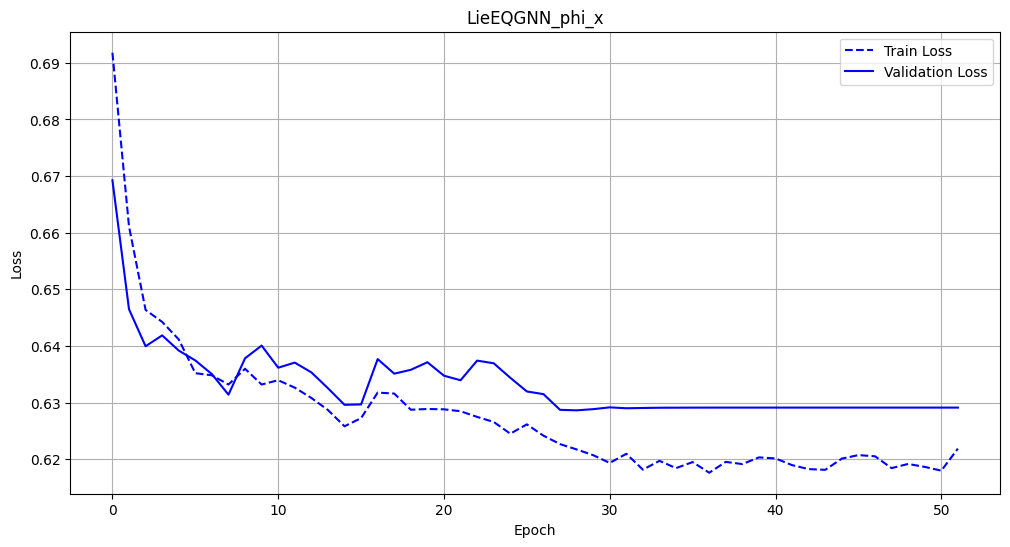

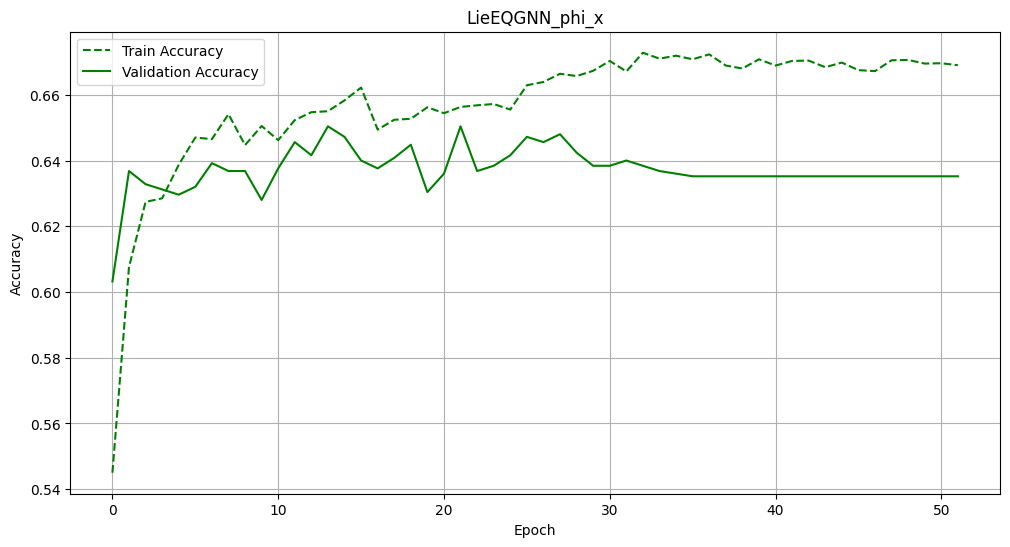

In [296]:
import matplotlib.pyplot as plt

# log_path = "logs/LorentzNet/train-result-epoch59.json"
# model_name = "LorentzNet"

# log_path = "logs/LieEQGNN/phi_m/train-result-epoch59.json"
# model_name = "LieEQGNN_phi_m"

# log_path = "logs/LieEQGNN/phi_h/train-result-epoch59.json"
# model_name = "LieEQGNN_phi_h"

log_path = "logs/LieEQGNN/phi_x/train-result-epoch51.json"
model_name = "LieEQGNN_phi_x"

# log_path = "logs/LieEQGNN/phi_e/train-result-epoch59.json"
# model_name = "LieEQGNN_phi_e"

# log_path = "logs/LieEQGNN/full_quantum/train-result-epoch59.json"
# model_name = "LieEQGNN_full_quantum"

with open(log_path) as f:

    data = json.load(f)
    epochs = data["epochs"]
    train_loss = data["train_loss"]
    val_loss = data["val_loss"]
    train_acc = data["train_acc"]
    val_acc = data["val_acc"]
    
    # Plotting Loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_loss, label='Train Loss', color='blue', linestyle='--')
    plt.plot(epochs, val_loss, label='Validation Loss', color='blue', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(model_name)
    plt.legend()
    plt.grid(True)
    plt.savefig("figures/{}_loss.png".format(model_name), dpi=300)
    plt.show()
    
    # Plotting Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_acc, label='Train Accuracy', color='green', linestyle='--')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='green', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(model_name)
    plt.legend()
    plt.grid(True)
    plt.savefig("figures/{}_accuracy.png".format(model_name), dpi=300)
    plt.show()

In [298]:
import json

import matplotlib.pyplot as plt



# List of log paths and model names

log_paths_and_model_names = [

    ("logs/LorentzNet/train-result-epoch59.json", "LorentzNet"),
    ("logs/LieEQGNN/phi_m/train-result-epoch59.json", "LieEQGNN_phi_m"),
    ("logs/LieEQGNN/phi_h/train-result-epoch48.json", "LieEQGNN_phi_h"),
    ("logs/LieEQGNN/phi_x/train-result-epoch59.json", "LieEQGNN_phi_x"),
    ("logs/LieEQGNN/phi_e/train-result-epoch50.json", "LieEQGNN_phi_e"),
    ("logs/LieEQGNN/full_quantum/train-result-epoch18.json", "LieEQGNN_full_quantum")
]



for log_path, model_name in log_paths_and_model_names:

    with open(log_path) as f:

        data = json.load(f)
        
        epochs = data["epochs"]
        train_loss = data["train_loss"]
        val_loss = data["val_loss"]
        train_acc = data["train_acc"]
        val_acc = data["val_acc"]

        # Plotting Loss

        plt.figure(figsize=(12, 6))
        plt.plot(epochs, train_loss, label='Train Loss', color='blue', linestyle='--')
        plt.plot(epochs, val_loss, label='Validation Loss', color='orange', linestyle='-')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(model_name)
        plt.legend()
        plt.grid(True)
        plt.savefig("figures/{}_loss.png".format(model_name), dpi=300)

        plt.close()

        

        # Plotting Accuracy

        plt.figure(figsize=(12, 6))
        plt.plot(epochs, train_acc, label='Train Accuracy', color='green', linestyle='--')
        plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', linestyle='-')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(model_name)
        plt.legend()
        plt.grid(True)
        plt.savefig("figures/{}_accuracy.png".format(model_name), dpi=300)
        plt.close()